In [ ]:
# Download the pre-trained weights. No top means it excludes the fully connected layer it uses for classification.
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2024-06-14 11:57:48--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.117.207, 142.250.99.207, 142.250.107.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.117.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   219MB/s    in 0.4s    

2024-06-14 11:57:49 (219 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

# Set the weights file you downloaded into a variable
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                include_top = False,
                                weights = None)

# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False

In [ ]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalizati

In [ ]:
# Choose `mixed7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [ ]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.4)(x)
# Add a final sigmoid layer for classification
x = layers.Dense  (12, activation='softmax')(x)

# Append the dense network to the base model
model = Model(pre_trained_model.input, x)

# Print the model summary. See your dense network connected at the end.
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalization[0][0

In [ ]:
# Set the training parameters
model.compile(optimizer = RMSprop(learning_rate=0.0001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

In [ ]:
import os
import zipfile
import random
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import gdown

# Install gdown if not already installed
# !pip install gdown

# Function to create directories if they don't exist
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

# Google Drive file ID and destination path
file_id = "1sTkmoqcZMPVNXajh9qTCVqWHaXMusQR-"
destination = "/content/garbage_classification_fourth.zip"

# Download the file from Google Drive
gdown.download(f"https://drive.google.com/uc?id={file_id}", destination, quiet=False)

# Extract the archive
with zipfile.ZipFile(destination, 'r') as zip_ref:
    zip_ref.extractall("tmp/")

# Define our example directories and files
base_dir = 'tmp/garbage_classification_fourth'

# Create train and validation directories
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
create_dir(train_dir)
create_dir(validation_dir)

# Categories
categories = ['Baterai', 'Botol Kaca', 'Botol Plastik', 'Cangkir', 'Elektronik', 'Kertas', 'Kotak',
              'Organik', 'Pakaian', 'Plastik', 'Sampah non olah', 'Sepatu'
              ]

# Create category directories within train and validation directories
for category in categories:
    create_dir(os.path.join(train_dir, category))
    create_dir(os.path.join(validation_dir, category))

# Split data into training and validation sets
for category in categories:
    category_dir = os.path.join(base_dir, category)
    files = os.listdir(category_dir)
    random.shuffle(files)

    split_index = int(len(files) * 0.8)
    train_files = files[:split_index]
    validation_files = files[split_index:]

    for file in train_files:
        shutil.move(os.path.join(category_dir, file), os.path.join(train_dir, category, file))

    for file in validation_files:
        shutil.move(os.path.join(category_dir, file), os.path.join(validation_dir, category, file))

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255.,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1.0/255.)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        batch_size=20,
                                                        class_mode='categorical',
                                                        target_size=(150, 150))

Downloading...
From (original): https://drive.google.com/uc?id=1sTkmoqcZMPVNXajh9qTCVqWHaXMusQR-
From (redirected): https://drive.google.com/uc?id=1sTkmoqcZMPVNXajh9qTCVqWHaXMusQR-&confirm=t&uuid=a6553079-13f2-4b67-a68c-f99659a1eae3
To: /content/garbage_classification_fourth.zip
100%|██████████| 264M/264M [00:09<00:00, 27.2MB/s]


Found 9212 images belonging to 12 classes.
Found 2305 images belonging to 12 classes.


In [ ]:
# Train the model.
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 30,
            epochs = 100,
            validation_steps = 30,
            verbose = 2)

Epoch 1/100
30/30 - 18s - loss: 1.7903 - accuracy: 0.4550 - val_loss: 1.2386 - val_accuracy: 0.5800 - 18s/epoch - 597ms/step
Epoch 2/100
30/30 - 7s - loss: 1.1311 - accuracy: 0.6486 - val_loss: 0.8608 - val_accuracy: 0.7200 - 7s/epoch - 232ms/step
Epoch 3/100
30/30 - 5s - loss: 1.0638 - accuracy: 0.6683 - val_loss: 0.6564 - val_accuracy: 0.7800 - 5s/epoch - 162ms/step
Epoch 4/100
30/30 - 6s - loss: 0.9490 - accuracy: 0.6807 - val_loss: 0.5352 - val_accuracy: 0.8267 - 6s/epoch - 206ms/step
Epoch 5/100
30/30 - 5s - loss: 0.8212 - accuracy: 0.7517 - val_loss: 0.5484 - val_accuracy: 0.8117 - 5s/epoch - 166ms/step
Epoch 6/100
30/30 - 6s - loss: 0.7393 - accuracy: 0.7650 - val_loss: 0.5769 - val_accuracy: 0.8133 - 6s/epoch - 205ms/step
Epoch 7/100
30/30 - 5s - loss: 0.7103 - accuracy: 0.7700 - val_loss: 0.5115 - val_accuracy: 0.8283 - 5s/epoch - 165ms/step
Epoch 8/100
30/30 - 6s - loss: 0.6916 - accuracy: 0.7717 - val_loss: 0.4641 - val_accuracy: 0.8533 - 6s/epoch - 206ms/step
Epoch 9/100
30

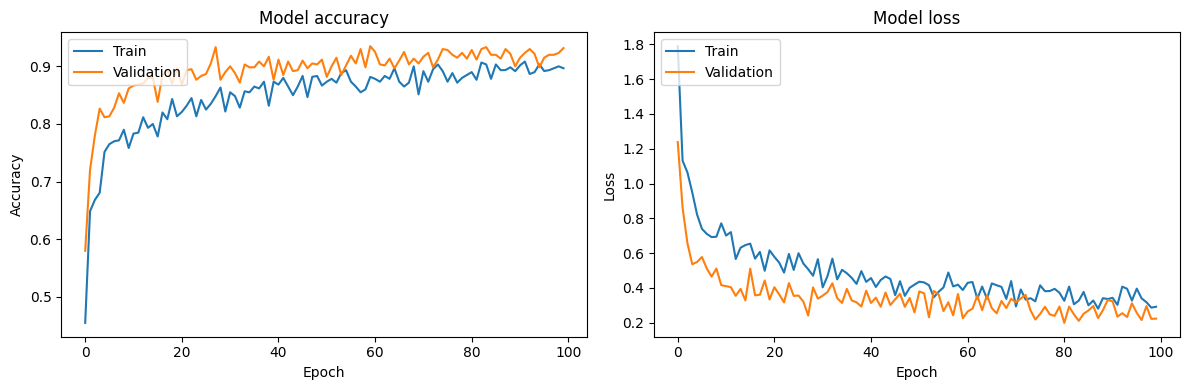

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Function to load and prepare an image
def load_and_prepare_image(img_path, target_size=(150, 150)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize to [0, 1] range
    return img_array

# Function to make predictions
def make_prediction(model, img_array, class_indices):
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)
    class_labels = {v: k for k, v in class_indices.items()}
    return class_labels[predicted_class[0]]

# Assuming `model` is already trained and available in memory
# Assuming `train_generator` is available to get class indices

# Path to the image you want to test
img_path = '/content/bp3.jpg'  # Change this to the path of the image you want to test

# Load and prepare the image
img_array = load_and_prepare_image(img_path)

# Make prediction
predicted_class = make_prediction(model, img_array, train_generator.class_indices)

print(f'Predicted class: {predicted_class}')

1/1 [==============================] - 0s 55ms/step
Predicted class: Plastik


In [ ]:
# Simpan model dalam format H5
model.save('model.h5')

In [ ]:
# Gunakan perintah TensorFlow.js converter untuk mengkonversi model H5 ke format JSON
!tensorflowjs_converter --input_format=keras /model.h5 /model-h5

/bin/bash: line 1: tensorflowjs_converter: command not found
